# (05) Création des visualisations

---

#### Connexion à la base de données

In [4]:
import os
import pandas as pd

In [5]:
from sqlalchemy import create_engine

In [6]:
user = 'postgres'
password = os.environ.get('pg_psw')
host = 'localhost'
port = '5432'
dbname = 'db_exac'  

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

---

### _01 - 10 articles avec le plus de reviews_

In [33]:
query_01 = pd.read_sql_query("""SELECT a.name as "Produit", COUNT(b.rating) AS "Nombre d'avis" 
                             FROM product a 
                             LEFT JOIN reviews b ON a.product_id = b.product_id 
                             GROUP BY a.name
                             ORDER BY "Nombre d'avis" DESC
                             LIMIT 10;""", engine)
query_01.head(10)

,Produit,Nombre d'avis
0,Logitech 915-000224 Harmony Ultimate One 15-D...,1604
1,Microsoft Surface Pro 4 Type Cover with Finger...,495
2,Sony SRSXB30/BLK XB30 Portable Wireless Speake...,477
3,Everest Elite 700 Around-Ear Wireless Headphon...,357
4,Slingbox M2,342
5,SAMSUNG 40'' Class FHD (1080P) Smart LED TV (U...,340
6,"Alpine - 6-1/2"" 2-Way Coaxial Car Speakers wit...",260
7,PNY Anarchy 16GB Kit (2x8GB) DDR4 2400MHz (PC4...,191
8,Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charc...,178
9,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,162


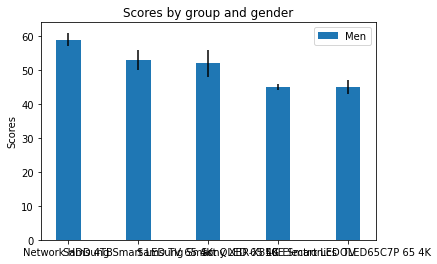

In [10]:
import matplotlib.pyplot as plt


labels = ['Network HDD 4TB', 'Samsung Smart LED TV 65 4K', 'Samsung Smart QLED 65 4K', 'Sony XBR-X850E Smart LED TV', 'LG Electronics OLED65C7P 65 4K']
men_means = [59, 53, 52, 45, 45]
men_std = [2, 3, 4, 1, 2]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Men')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

[(0.0, 1800.0),
 Text(0.5, 0, "Nombre d'avis"),
 Text(0, 0.5, 'Produits'),
 Text(0.5, 1.0, '10 produits les plus notés')]

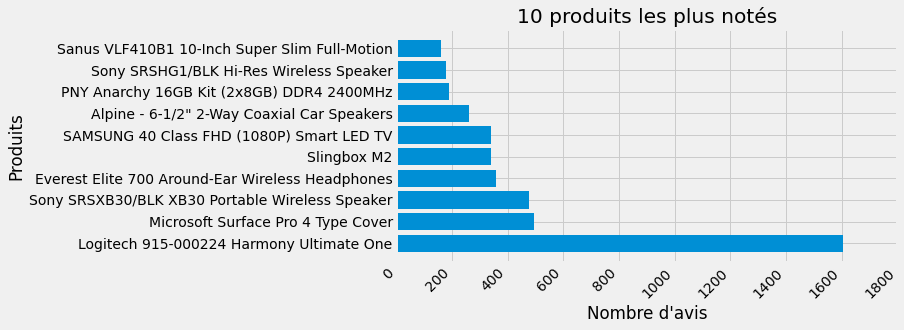

In [38]:
import numpy as np
import matplotlib.pyplot as plt


data = {'Logitech 915-000224 Harmony Ultimate One': 1604,
        'Microsoft Surface Pro 4 Type Cover': 495,
        'Sony SRSXB30/BLK XB30 Portable Wireless Speaker': 477,
        'Everest Elite 700 Around-Ear Wireless Headphones': 357,
        'Slingbox M2': 342,
        'SAMSUNG 40'' Class FHD (1080P) Smart LED TV': 340,
        'Alpine - 6-1/2" 2-Way Coaxial Car Speakers': 260,
        'PNY Anarchy 16GB Kit (2x8GB) DDR4 2400MHz': 191,
        'Sony SRSHG1/BLK Hi-Res Wireless Speaker': 178,
        'Sanus VLF410B1 10-Inch Super Slim Full-Motion': 162}

group_data = list(data.values())
group_names = list(data.keys())
group_mean = np.mean(group_data)

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 1800], xlabel="Nombre d'avis", ylabel='Produits',
       title='10 produits les plus notés')

---

### _02 - Produits en promotion ou non_

In [19]:
query_02 = pd.read_sql_query("""SELECT a.issale AS "Produits", COUNT(a.product_id) AS "En promotion"
                                FROM prices a
                                GROUP BY a.issale 
                                ORDER BY "En promotion" DESC
                                LIMIT 10""", engine)
query_02.head()

,Produits,En promotion
0,False,5508
1,True,1741
2,None,50


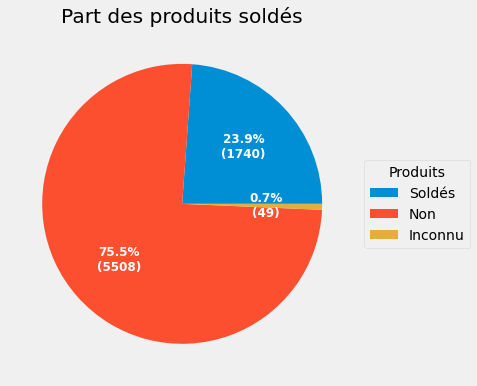

In [29]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 6), subplot_kw=dict(aspect="equal"))

contenu = ["1741 Soldés",
          "5508 Non",
          "50 Inconnu"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          title="Produits",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Part des produits soldés")

plt.show()

---

### _03 - 10 articles les mieux notés avec plus de 30 notes_

In [40]:
query_03 = pd.read_sql_query("""
    SELECT a.name, AVG(b.rating)FROM product a 
    LEFT JOIN reviews b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.rating) > 30
    ORDER BY avg(rating) DESC
    LIMIT 10;
    """, engine)
query_03.head(10)

,name,avg
0,Logitech G403 Wireless Gaming Mouse with High ...,4.852273
1,"AW6500 All-Weather Outdoor Speaker (White, Sin...",4.851852
2,Sony Mini Digital Video Cassettes - DVC - 1 Hour,4.830000
3,Corsair CMSA8GX3M2A1066C7 Apple 8 GB Dual Chan...,4.798246
4,2TB Red 5400 rpm SATA III 3.5 Internal NAS HDD,4.796296
5,Bowers & Wilkins P7 Wired Over Ear Headphones,4.766355
6,"JBL - 6"" x 8"" 2-Way Coaxial Car Speakers with ...",4.762887
7,"Midland Weather Alert Radio, 1.0 CT",4.659091
8,Sony SRSXB30/BLK XB30 Portable Wireless Speake...,4.637317
9,Flipside 300 Backpack (Black),4.625954


---

### _04 - Marques les plus représentées_

In [43]:
query_04 = pd.read_sql_query("""
    SELECT a.brand, COUNT(b.product_id) as "Nombre de produits"
    FROM manufacturer a
    LEFT JOIN product b on a.product_id=b.product_id 
    GROUP BY a.brand
    ORDER BY "Nombre de produits" DESC;
    """, engine)

query_04.head(10)

,brand,Nombre de produits
0,Inconnu,483
1,Sony,22
2,Yamaha,16
3,Pioneer,8
4,Samsung,8
5,YAMAHA,7
6,Apple,7
7,Elitescreens,6
8,Alpine,6
9,Denaq,6


---

### _05 - Couleurs les plus présentes_

In [47]:
query_05 = pd.read_sql_query("""
    SELECT a.colors as "Couleur", COUNT(a.colors) as "Nombre de produits"
    FROM product a
    GROUP BY a.colors
    ORDER BY "Nombre de produits" DESC
""", engine)

query_05.head(20)

,Couleur,Nombre de produits
0,Inconnue,812
1,Black,7
2,Multicolor,3
3,"Black,White",2
4,White,2
5,"Gray,Color",1
6,"Navy,Black,Gray,Blue",1
7,"Multicolor,Black,Grey",1
8,Blue,1
9,"Blue,Graphite,Blue steel,Black,Merlot,Blizzard",1


---

### _06 - Pourcentage de produits disponibles_

In [49]:
query_06 = pd.read_sql_query("""
    SELECT a.availability as "Disponibilité", COUNT(a.product_id) as "Nombre de produits"
    FROM prices a
    GROUP BY a.availability 
    ORDER BY "Nombre de produits" DESC
""", engine)

query_06.head(15)

,Disponibilité,Nombre de produits
0,In Stock,3172
1,Yes,2136
2,yes,893
3,TRUE,663
4,Out Of Stock,115
5,Special Order,109
6,More on the Way,91
7,None,50
8,undefined,40
9,sold,22


---

### _07 - Différentes currency_

In [50]:
query_07 = pd.read_sql_query("""
    SELECT a.currency as "Devise", COUNT(a.product_id) as "Nombre"
    FROM prices a
    GROUP BY a.currency 
    ORDER BY "Nombre" DESC
""", engine)

query_07.head()

,Devise,Nombre
0,USD,7248
1,None,50
2,CAD,1


---

### _08 - Différentes conditions_

In [59]:
query_08 = pd.read_sql_query("""
    SELECT a.condition as "Etat", COUNT(a.product_id) as "Nombre"
    FROM prices a
    GROUP BY a."condition" 
    ORDER BY "Nombre" DESC
""", engine)

query_08.head(15)

,Etat,Nombre
0,New,6226
1,new,699
2,Used,143
3,New other (see details),92
4,Manufacturer refurbished,55
5,None,50
6,Seller refurbished,15
7,Refurbished,11
8,pre-owned,3
9,refurbished,2


---

### _09 - Articles les plus chers en moyenne_

In [57]:
query_09 = pd.read_sql_query("""
    SELECT a.name, AVG(b.amountmax)
    FROM product a 
    LEFT JOIN prices b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.amountmax) > 5
    ORDER BY AVG(b.amountmax) DESC
    LIMIT 10;
""", engine)

query_09.head(10)

,name,avg
0,Razer - Blade Pro 17.3 4K Ultra HD Touch-Scree...,3975.990112
1,Refurbished Samsung Curved 65 4K (2160P) Smart...,3937.802434
2,Sony - 55 Class - OLED - A1E Series - 2160p - ...,3528.483896
3,LG Electronics OLED65C7P 65-Inch 4K Ultra HD S...,3246.363585
4,LG - 65 Class - OLED - B7A Series - 2160p - Sm...,3123.529222
5,XBR-X850E-Series 75-Class HDR UHD Smart LED TV,2939.151790
6,SunBriteTV - Signature Series - 43 Class - LED...,2799.707136
7,Samsung - 65 Class - LED - Q7F Series - 2160p ...,2699.323324
8,MU9000-Series 65-Class HDR UHD Smart LED TV,2604.316180
9,Samsung - 55 Class - LED - Curved - Q7C Series...,2494.725623


---

### _10 - Articles les moins chers en moyenne_

In [58]:
query_10 = pd.read_sql_query("""
    SELECT a.name, AVG(b.amountmin)
    FROM product a 
    LEFT JOIN prices b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.amountmin) > 5
    ORDER BY AVG(b.amountmin) ASC
    LIMIT 10;
""", engine)

query_10.head(10)

,name,avg
0,"Portable Bluetooth Wireless Speaker, Red",13.953333
1,Samsung - Adaptive Fast Charging Wall Charger ...,15.451200
2,"Lowepro Dashpoint AVC 1, Blue",15.826667
3,House of Marley Smile Jamaica In-Ear Earbuds,19.689166
4,PP999 Phono Preamplifier,19.862857
5,DENAQ - AC Power Adapter and Charger for Selec...,20.341667
6,Boytone - Portable Bluetooth Speaker - Blue,23.823333
7,Roll Bar Mount,24.217143
8,DENAQ - AC Power Adapter and Charger for Selec...,26.306667
9,TL-SG108 8-Port 10/100/1000 Mbps Unmanaged Des...,26.347273


---

 ### _11 - Merchant les plus représentés_

In [61]:
query_11 = pd.read_sql_query("""
    SELECT a.merchant as "Site marchand", COUNT(a.merchant) as "Nombre"
    FROM prices a
    GROUP BY "Site marchand"
    ORDER BY "Nombre" DESC;
""", engine)

query_11.head(10)

,Site marchand,Nombre
0,Bestbuy.com,2806
1,bhphotovideo.com,1509
2,Walmart.com,664
3,Beach Camera,201
4,AMI Ventures Inc,63
5,buydig,53
6,Focus Camera,48
7,gear4less,43
8,echo-and-optics,40
9,Beach Audio Inc,39


---

### _12 - Nombre de commentaires "Helpful"_

In [62]:
query_12 = pd.read_sql_query("""
    SELECT a.dorecommend as "Recommande le produit", COUNT(a.product_id) as "Nombre"
    FROM reviews a
    GROUP BY "Recommande le produit"
    ORDER BY "Nombre" DESC;
""", engine)

query_12.head(10)

,Recommande le produit,Nombre
0,True,5401
1,None,2226
2,False,507


---

### _13 - Username avec le plus d'avis_

In [63]:
query_13 = pd.read_sql_query("""
    SELECT a.username as "Username", COUNT(a.username) as "Nombre"
    FROM reviews a
    GROUP BY "Username"
    ORDER BY "Nombre" desc
    LIMIT 10;
""", engine)

query_13.head(10)

,Username,Nombre
0,ByAmazon Customer,63
1,Mike,21
2,John,16
3,Chris,14
4,James,13
5,Anonymous,13
6,Jeff,12
7,Dave,11
8,Steve,11
9,Bill,11


---

### _14 - Manufacturer les plus présents_

In [ ]:
query_14 = pd.read_sql_query("""
    SELECT a.manufacturer as "Réference", COUNT(a.manufacturer) as "Nombre"
    FROM manufacturer a
    GROUP BY "Réference"
    ORDER BY "Nombre" desc
    LIMIT 10;
""", engine)

query_12.head(10)

---

### _15 - Colonnes avec le plus de valeurs "Null"_

In [21]:
query_15 = pd.read_sql_query("""
    SELECT ...
    ;
""", engine)

query_15.head(10)

,title,character
0,Scoop,Sid Waterman
1,Manhattan,Isaac Davis
2,Annie Hall,Alvy Singer
3,Maris et femmes,Prof. Gabriel 'Gabe' Roth


---